In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import datetime

import ConstructPortfolio as cp #this will allow us to modularize the code!
#using "ConstructPortfolio.py" that is stored in the same directory! 
#(not using "ConstructPortfolio.ipynb")



/Users/bardiafarajnejad/Desktop/1st Half MFE/AFP/Final Delivery/MFE Group 16 AFP Code


# Following index inclusion, sell stock will pay off
# Following index removal, buy stock will pay off
# However, profits are tiny

##################################
# However, leading up to index inclusion, the opposite is true!

In [2]:
#### Please run the line below once in order to get "data_with_rets.pkl" from "afp_data_sample_1995_onward_v2.csv"
#cp.get_data(flag=True)

data = pd.read_pickle('data_with_rets.pkl')
data

,tradedate,osid,symbol,coname,sector_group,max_dt,previoustradedate,tickssinceipo,alpha,stdev_alpha,...,ret1d_lag,alpha1d_lag,ret5d_lag,alpha5d_lag,ret10d_lag,alpha10d_lag,ret15d_lag,alpha15d_lag,ret20d_lag,alpha20d_lag
0,19950103,10032,ACK,Armstrong Holdings Inc,7.0,19970827,19941230.0,8056,0.010006,0.004670,...,0.00000,-0.003112,0.176850,0.166677,0.131841,0.102035,0.144700,0.123317,0.138261,0.106187
1,19950104,10032,ACK,Armstrong Holdings Inc,7.0,19970827,19950103.0,8057,-0.003112,0.004656,...,0.01929,0.019820,0.131835,0.124719,0.125412,0.099894,0.173638,0.151438,0.144692,0.115932
2,19950105,10032,ACK,Armstrong Holdings Inc,7.0,19970827,19950104.0,8058,0.019820,0.005805,...,0.04732,0.045571,0.119876,0.112258,0.094651,0.075155,0.170357,0.145504,0.135652,0.101416
3,19950106,10032,ACK,Armstrong Holdings Inc,7.0,19970827,19950105.0,8059,0.045571,0.009709,...,0.03313,0.032296,0.069278,0.054748,0.063264,0.050293,0.096391,0.070299,0.090370,0.047479
4,19950109,10032,ACK,Armstrong Holdings Inc,7.0,19970827,19950106.0,8060,0.032296,0.010892,...,0.06706,0.063220,0.058317,0.037605,0.020420,0.006697,0.046651,0.026290,0.072892,0.026535
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2912427,20210805,78696,COOK,Traeger Inc,7.0,20210805,20210804.0,6,0.047968,0.026349,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2912428,20210806,78722,WEBR,Weber Inc Cl A,NaN,20210809,20210805.0,2,0.000000,0.000000,...,0.08190,0.080042,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2912429,20210809,78722,WEBR,Weber Inc Cl A,7.0,20210809,20210806.0,3,0.080042,0.025773,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2912430,20210901,78803,FCUV,Focus Universal Inc,NaN,20210902,20210831.0,2,0.000000,0.000000,...,-0.07106,-0.072293,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Now, let's trade on the times when 'sp100f', 'sp500f', 'nasdaq100f' flip between 0 and 1
###### Buy when flip is from 0 to 1, so when df['sp100f'].dff(1)>0
###### Sell when flip is from 1 to 0, so when df['sp100f'].dff(1)<0
### with 1 day, 1 week, 2 weeks, 3 weeks, and 4 weeks holding period 
### (AHEAD, not backward... so our ret, ret5d, 10d, 15d, and 20d needs to be forward)
### Thus, we will use ret5d_'lag' !!

# Set buy_tomorrow>0 when sp100f, sp500f, nasdaq100f flips from 0 to 1
# Set Sell_tomorrow>0 when sp100f, sp500f, nasdaq100f flips from 1 to 0

In [3]:
data['sp100f'] = data['sp100f'].replace(np.nan, 0) #place a 0 in order to count non_zeros first
data['sp500f'] = data['sp500f'].replace(np.nan, 0) #place a 0 in order to count non_zeros first
data['nasdaq100f'] = data['nasdaq100f'].replace(np.nan, 0)

#define event using indicator for buy and sell:
data = data.sort_values(['osid', 'tradedate']).reset_index(drop=True).copy()

data = data.loc[data['sp100f'].notna(),:].reset_index(drop=True).copy()
data = data.loc[data['sp500f'].notna(),:].reset_index(drop=True).copy()
data = data.loc[data['nasdaq100f'].notna(),:].reset_index(drop=True).copy()

data['sell_sp100_tomorrow'] = np.where(data[['osid','sp100f']].groupby(['osid'])['sp100f'].diff(1) == 1, 1, 0)
data['sell_sp500_tomorrow'] = np.where(data[['osid','sp500f']].groupby(['osid'])['sp500f'].diff(1) == 1, 1, 0)
data['sell_nasdaq_tomorrow'] = np.where(data[['osid','nasdaq100f']].groupby(['osid'])['nasdaq100f'].diff(1) == 1, 1, 0)

data['buy_sp100_tomorrow'] = np.where(data[['osid','sp100f']].groupby(['osid'])['sp100f'].diff(1) == -1, 1, 0)
data['buy_sp500_tomorrow'] = np.where(data[['osid','sp500f']].groupby(['osid'])['sp500f'].diff(1) == -1, 1, 0)
data['buy_nasdaq_tomorrow'] = np.where(data[['osid','nasdaq100f']].groupby(['osid'])['nasdaq100f'].diff(1) == -1, 1, 0)

data['buy_tomorrow'] = data['buy_sp100_tomorrow'] + data['buy_sp500_tomorrow'] + data['buy_nasdaq_tomorrow']
data['sell_tomorrow'] = data['sell_sp100_tomorrow'] + data['sell_sp500_tomorrow'] + data['sell_nasdaq_tomorrow']

data.drop(['buy_sp100_tomorrow','buy_sp500_tomorrow','buy_nasdaq_tomorrow',\
           'sell_sp100_tomorrow','sell_sp500_tomorrow','sell_nasdaq_tomorrow'], axis=1, inplace=True)

#data[['tradedate','symbol','sp100f','sp500f','nasdaq100f','buy_tomorrow','sell_tomorrow']]


print('Total number of Buys: ',np.count_nonzero(data['buy_tomorrow']))
print('Total number of Sells: ',np.count_nonzero(data['sell_tomorrow']))

print('Unique buy_tomorrow values: ',np.unique(data['buy_tomorrow'])) #there is at least one '2' that occurs, which means that one stock was included in 2 indices in one day!
print('Unique sell_tomorrow values: ',np.unique(data['sell_tomorrow'])) #there is at least one '2' that occurs, which means that one stock was removed from 2 indices in one day!



Total number of Buys:  237
Total number of Sells:  439
Unique buy_tomorrow values:  [0 1 2]
Unique sell_tomorrow values:  [0 1 2]


In [4]:
data = cp.trade_on_valid_lags_only(data)


There are  0  problems for buying

There are  0  problems for selling
Total number of Buys:  237
Total number of Sells:  439


# Now we can trade!
### Holding period of 1 week, 2 weeks, 3 weeks, and 4 weeks with equal weighted portfolios!

# First, create daily equal weighted portfolio weights and returns (NOT AT THE WEEKLY frequency because that will mess up the implementation of the portfolio!). Problem is:

##### Think (part 1): 1st signal on Monday- want to buy on Tuesday and hold for 1 week in an equal weighted portfolio
##### Think (part 2): 2nd signal on Thursday- want to buy on Friday and hold for 1 week in an equal weighted portfolio
##### Think (part 3): Will have overlapping portfolio between 1st and 2nd signal on Friday and on Monday

## Then, for 1 week, 2 week, 3 week, and 4 week holding periods, we must do the following:
##### extend "buy_tomorrow" and "sell_tomorrow" forward for 4 more trading days

In [5]:
data_smaller,data_smaller5,data_smaller10,data_smaller15,data_smaller20 = cp.pull_signal_forward(data)

data_smaller20 = cp.trade_on_valid_lags_only(data_smaller20)
data_smaller15 = cp.trade_on_valid_lags_only(data_smaller15)
data_smaller10 = cp.trade_on_valid_lags_only(data_smaller10)
data_smaller5 = cp.trade_on_valid_lags_only(data_smaller5)
data_smaller = cp.trade_on_valid_lags_only(data_smaller)



There are  0  problems for buying

There are  1  problems for selling
Total number of Buys:  4109
Total number of Sells:  8724

There are  0  problems for buying

There are  1  problems for selling
Total number of Buys:  3114
Total number of Sells:  6549

There are  0  problems for buying

There are  0  problems for selling
Total number of Buys:  2106
Total number of Sells:  4372

There are  0  problems for buying

There are  0  problems for selling
Total number of Buys:  1082
Total number of Sells:  2191

There are  0  problems for buying

There are  0  problems for selling
Total number of Buys:  232
Total number of Sells:  439


# First, do 1 day holding period: data_smaller
# Next, do 5 day holding period: data_smaller5
# Next, do 10 day holding period: data_smaller10
# Next, do 15 day holding period: data_smaller15
# Next, do 20 day holding period: data_smaller20



There are  0  returns that dont match using .mean() vs. using equal weights

There are  0  alphas that dont match using .mean() vs. using equal weights

There are  0  returns that dont match using .mean() vs. using equal weights

There are  0  alphas that dont match using .mean() vs. using equal weights

All weights sum to one for Buys

All weights sum to one for Sells
Regression for Buy Portfolio
                            OLS Regression Results                            
Dep. Variable:           ew_return-RF   R-squared:                       0.045
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     1.095
Date:                Sat, 04 Dec 2021   Prob (F-statistic):              0.368
Time:                        18:53:55   Log-Likelihood:                 259.20
No. Observations:                 147   AIC:                            -504.4
Df Residuals:                     140   BIC: 

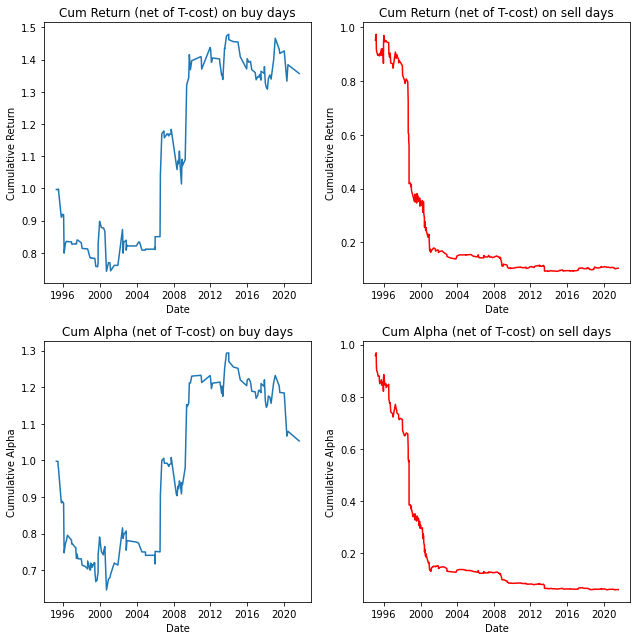

In [6]:
# 1 day holding period
cp.get_returns_turnover_Tcost_summary_plusPlots(data_smaller)


There are  0  returns that dont match using .mean() vs. using equal weights

There are  0  alphas that dont match using .mean() vs. using equal weights

There are  0  returns that dont match using .mean() vs. using equal weights

There are  0  alphas that dont match using .mean() vs. using equal weights

All weights sum to one for Buys

All weights sum to one for Sells
Regression for Buy Portfolio
                            OLS Regression Results                            
Dep. Variable:           ew_return-RF   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.241
Date:                Sat, 04 Dec 2021   Prob (F-statistic):              0.283
Time:                        18:54:16   Log-Likelihood:                 989.62
No. Observations:                 628   AIC:                            -1965.
Df Residuals:                     621   BIC: 

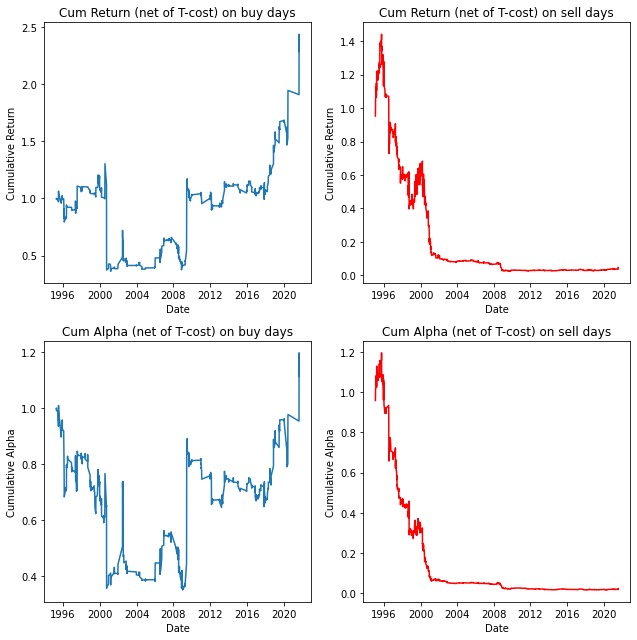

In [7]:
# 5 day holding period
cp.get_returns_turnover_Tcost_summary_plusPlots(data_smaller5)


There are  0  returns that dont match using .mean() vs. using equal weights

There are  0  alphas that dont match using .mean() vs. using equal weights

There are  0  returns that dont match using .mean() vs. using equal weights

There are  0  alphas that dont match using .mean() vs. using equal weights

All weights sum to one for Buys

All weights sum to one for Sells
Regression for Buy Portfolio
                            OLS Regression Results                            
Dep. Variable:           ew_return-RF   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.5219
Date:                Sat, 04 Dec 2021   Prob (F-statistic):              0.792
Time:                        18:54:33   Log-Likelihood:                 1835.9
No. Observations:                1161   AIC:                            -3658.
Df Residuals:                    1154   BIC: 

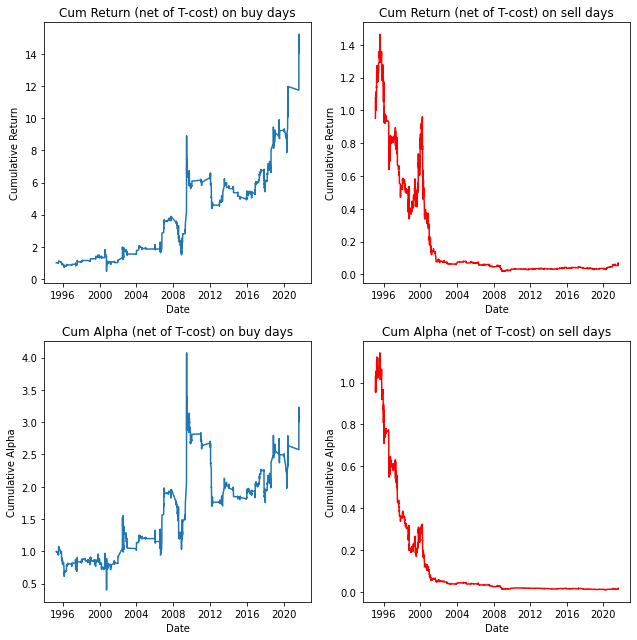

In [8]:
# 10 day holding period
cp.get_returns_turnover_Tcost_summary_plusPlots(data_smaller10)


There are  0  returns that dont match using .mean() vs. using equal weights

There are  0  alphas that dont match using .mean() vs. using equal weights

There are  0  returns that dont match using .mean() vs. using equal weights

There are  0  alphas that dont match using .mean() vs. using equal weights

All weights sum to one for Buys

All weights sum to one for Sells
Regression for Buy Portfolio
                            OLS Regression Results                            
Dep. Variable:           ew_return-RF   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.037
Date:                Sat, 04 Dec 2021   Prob (F-statistic):              0.399
Time:                        18:54:50   Log-Likelihood:                 2698.3
No. Observations:                1634   AIC:                            -5383.
Df Residuals:                    1627   BIC: 

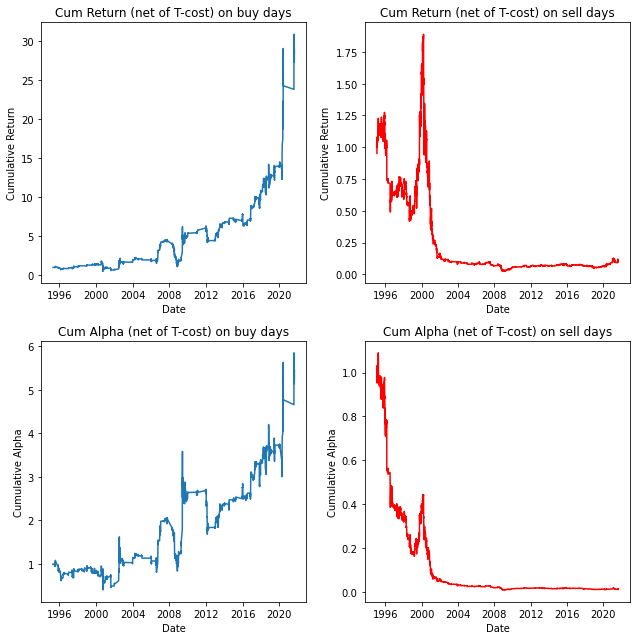

In [9]:
# 15 day holding period
cp.get_returns_turnover_Tcost_summary_plusPlots(data_smaller15)


There are  0  returns that dont match using .mean() vs. using equal weights

There are  0  alphas that dont match using .mean() vs. using equal weights

There are  2  returns that dont match using .mean() vs. using equal weights

There are  0  alphas that dont match using .mean() vs. using equal weights

All weights sum to one for Buys

All weights sum to one for Sells
Regression for Buy Portfolio
                            OLS Regression Results                            
Dep. Variable:           ew_return-RF   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.8819
Date:                Sat, 04 Dec 2021   Prob (F-statistic):              0.507
Time:                        18:55:08   Log-Likelihood:                 3524.2
No. Observations:                2064   AIC:                            -7034.
Df Residuals:                    2057   BIC: 

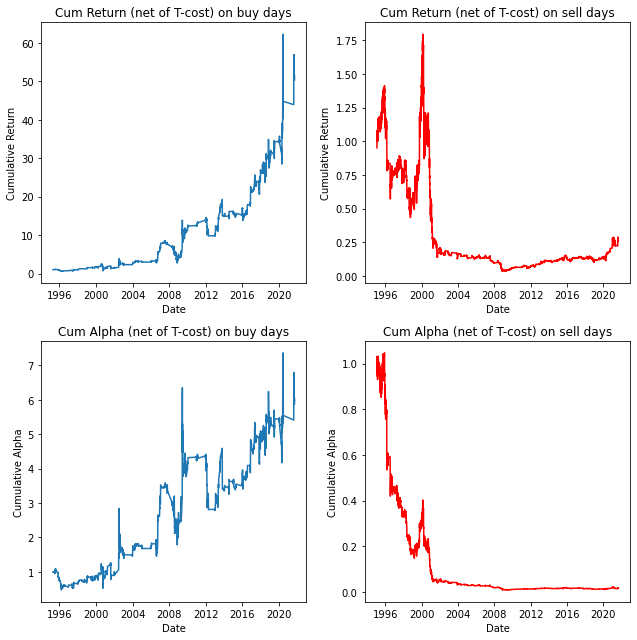

In [10]:
# 20 day holding period
cp.get_returns_turnover_Tcost_summary_plusPlots(data_smaller20)